# Name :- Ishant Kundra 

# UIN :- 934008421

# Assignment-2

# Step 2 OF The Assignment 2

##  Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import LabelEncoder

## Load the Dataset

In [2]:
file_path = 'Employee.csv'
data = pd.read_csv(file_path)

## Encode Categorical Variables

In [3]:
# Identify categorical variables to encode
categorical_columns = ['Education', 'City', 'EverBenched']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

## Define Features and Target Variable

In [4]:
# Exclude protected attributes and target variable from features
X = data.drop(columns=['Age', 'Gender', 'LeaveOrNot'])
y = data['LeaveOrNot']

## Split the Data into Training and Testing Sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Initialize and Train the Random Forest Classifier

In [6]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Predict on Test Data

In [7]:
y_pred = rf_classifier.predict(X_test)
y_probs = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities for calibration curve

## Prepare Data for Bias Detection Analysis

In [8]:
# Join Age and Gender back for analysis
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Actual'] = y_test
X_test_with_predictions['Predicted'] = y_pred
X_test_with_predictions = X_test_with_predictions.join(data[['Age', 'Gender']], how='left', rsuffix='_true')

## Define Function to Calculate Metrics for Bias Detection

In [9]:
def calculate_metrics(df, group_col, group_values):
    metrics = {}
    for value in group_values:
        group_df = df[df[group_col] == value]
        leave_rate = group_df['Actual'].mean()
        
        # Calculate Type 1 and Type 2 errors
        fp = ((group_df['Actual'] == 0) & (group_df['Predicted'] == 1)).sum()
        tn = ((group_df['Actual'] == 0) & (group_df['Predicted'] == 0)).sum()
        fn = ((group_df['Actual'] == 1) & (group_df['Predicted'] == 0)).sum()
        tp = ((group_df['Actual'] == 1) & (group_df['Predicted'] == 1)).sum()
        type1_error_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        type2_error_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
        metrics[value] = {'Leave Rate': leave_rate, 'Type 1 Error Rate': type1_error_rate, 'Type 2 Error Rate': type2_error_rate}
    return metrics

## Calculate and Print Metrics for Age and Gender Groups

In [10]:
# Age groups
X_test_with_predictions['AgeGroup'] = X_test_with_predictions['Age'].apply(lambda x: '<30' if x < 30 else '>=30')
age_metrics = calculate_metrics(X_test_with_predictions, 'AgeGroup', ['<30', '>=30'])

# Gender groups
gender_metrics = calculate_metrics(X_test_with_predictions, 'Gender', ['Male', 'Female'])  

# Convert metrics dictionaries to DataFrames
age_metrics_df = pd.DataFrame(age_metrics).T
gender_metrics_df = pd.DataFrame(gender_metrics).T

print("Age Metrics:\n", age_metrics_df)
print("\nGender Metrics:\n", gender_metrics_df)


Age Metrics:
       Leave Rate  Type 1 Error Rate  Type 2 Error Rate
<30     0.375679           0.057391           0.387283
>=30    0.273684           0.052174           0.376923

Gender Metrics:
         Leave Rate  Type 1 Error Rate  Type 2 Error Rate
Male      0.243276           0.056543           0.452261
Female    0.479239           0.053156           0.335740


## Plot Calibration Curves

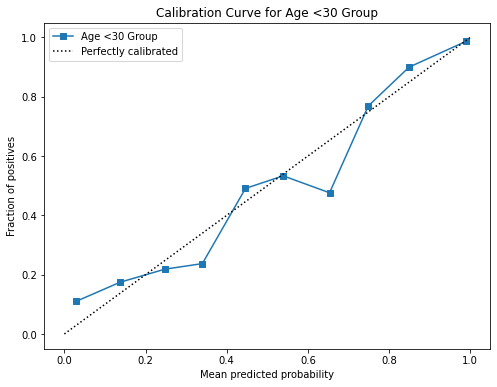

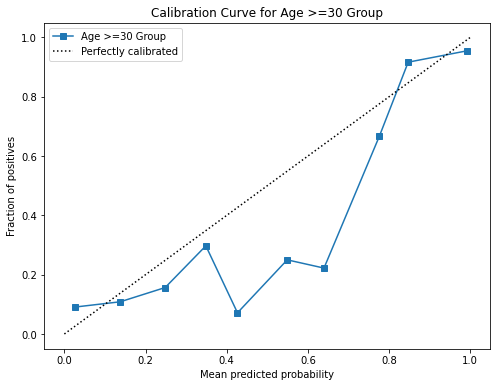

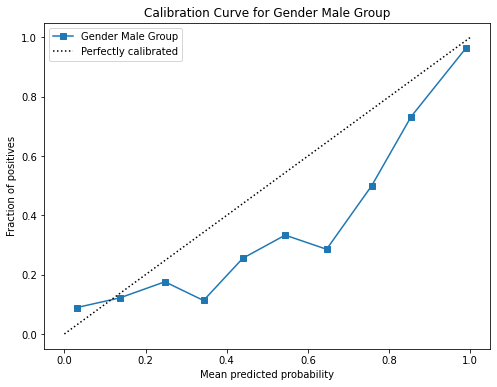

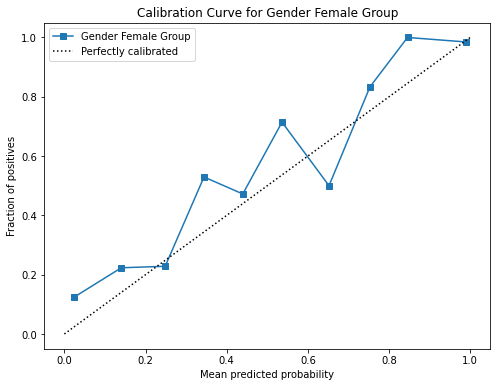

In [11]:
def plot_calibration_curve(y_true, y_prob, group_name):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{group_name} Group")
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration Curve for {group_name} Group')
    plt.legend()
    plt.show()

# Plot calibration curves for each group
for group in ['<30', '>=30']:
    group_condition = X_test_with_predictions['AgeGroup'] == group
    plot_calibration_curve(X_test_with_predictions.loc[group_condition, 'Actual'], y_probs[group_condition], f'Age {group}')

for gender in ['Male', 'Female']:
    group_condition = X_test_with_predictions['Gender'] == gender
    plot_calibration_curve(X_test_with_predictions.loc[group_condition, 'Actual'], y_probs[group_condition], f'Gender {gender}')

# Step 3 of the Assignment-2

## Figure out how much each feature (such as education,age,city,etc.) contributes to the model's prediction on one randomly selected data point.
### a. Using LIME


In [12]:
for col in categorical_columns:
    le = label_encoders[col]
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Mapping for {col}: {mapping}")

Mapping for Education: {'Bachelors': 0, 'Masters': 1, 'PHD': 2}
Mapping for City: {'Bangalore': 0, 'New Delhi': 1, 'Pune': 2}
Mapping for EverBenched: {'No': 0, 'Yes': 1}


In [13]:
import time

start_time = time.time()

In [14]:
import lime
import lime.lime_tabular
import warnings
warnings.filterwarnings('ignore')

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=X_train.columns,
                                                   class_names=['Not Leave', 'Leave'],
                                                   verbose=True, mode='classification')


i = 5
exp = explainer.explain_instance(X_test.values[i], rf_classifier.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True)

lime_execution_time = time.time() - start_time


Intercept 0.5265252573401964
Prediction_local [0.53439903]
Right: 0.12634812409812407


In [15]:
exp.as_list()

[('0.00 < City <= 1.00', -0.0794554191002243),
 ('JoiningYear <= 2013.00', 0.05073955492078877),
 ('Education > 0.00', 0.04414283474736125),
 ('EverBenched <= 0.00', -0.01894560242528835),
 ('ExperienceInCurrentDomain <= 2.00', 0.0113924021705544),
 ('PaymentTier <= 3.00', 0.0)]

In [16]:
lime_execution_time = time.time() - start_time
print(f"LIME Analysis took {lime_execution_time} seconds")

LIME Analysis took 0.23216700553894043 seconds


### b. Using SHAP

In [17]:
# For SHAP
start_time = time.time()

In [18]:
import shap

shap_explainer = shap.TreeExplainer(rf_classifier)

# Calculate Shap values for one observation (the same index 'i' as used in LIME)
shap_values = shap_explainer.shap_values(X_test.iloc[i])


In [19]:
shap.initjs()
shap.force_plot(shap_explainer.expected_value[1], shap_values[1], X_test.iloc[i])


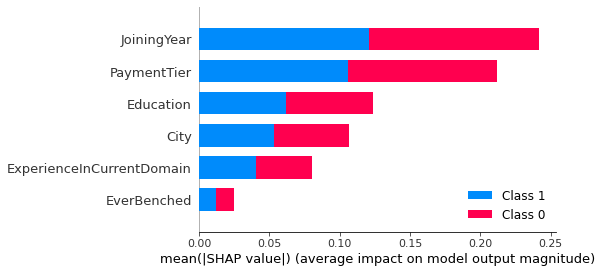

In [20]:
shap_values = shap_explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [21]:
print(type(shap_values))
print(len(shap_values))

<class 'list'>
2


In [22]:
shap_execution_time = time.time() - start_time

In [23]:
print(f"SHAP Analysis took {shap_execution_time} seconds")

SHAP Analysis took 13.803340911865234 seconds


# Step 4 

# Visualizing LIME results:

In [24]:
exp.show_in_notebook(show_all=False)  

# Visualizing SHAP results:

In [25]:
shap_values = shap_explainer.shap_values(X_test)
print(np.array(shap_values).shape)

(2, 1396, 6)


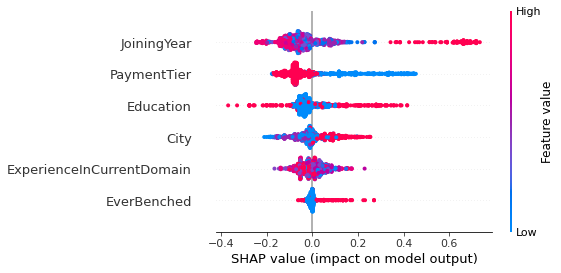

In [26]:
shap.summary_plot(shap_values[1], X_test)